In [1]:
from cmb.configs.utils import Configs
from cmb.datasets.jetclass import JetsClassData

config = Configs('epic.yaml') 
jets = JetsClassData(config.data)

INFO: created experiment instance beta-gauss_to_tops_ConditionalMarkovBridge_EPiC_2024.09.30_19h11_381


## JetClass data visualization

In [2]:
(jets.target.continuous.shape, 
jets.source.continuous.shape, 
jets.target.mask.shape,
jets.source.mask.shape)

(torch.Size([100000, 128, 3]),
 torch.Size([100000, 128, 3]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]))

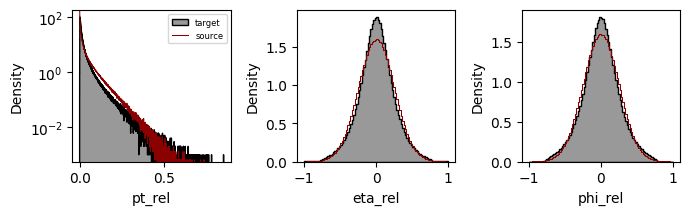

In [5]:
mask_target = (jets.target.mask > 0).squeeze() 
mask_source = (jets.source.mask > 0).squeeze() 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))
jets.target.histplot('pt_rel', mask=mask_target, ax=ax[0], stat='density', log_scale=(False,True), color='k', alpha=0.4, label='target')
jets.source.histplot('pt_rel', mask=mask_source, ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('eta_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02,ax=ax[1], stat='density',  color='k', alpha=0.4, label='target')
jets.source.histplot('eta_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02, ax=ax[1], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('phi_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02, ax=ax[2], stat='density', color='k', alpha=0.4, label='target')
jets.source.histplot('phi_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02,ax=ax[2], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

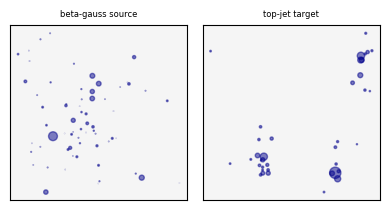

In [6]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,2, figsize=(4, 2.2))
jets.source.display_cloud(idx=10,  scale_marker=100.0, ax=ax[0])
jets.target.display_cloud(idx=10,  scale_marker=100.0, ax=ax[1])
ax[0].set_title('beta-gauss source', fontsize=6)
ax[1].set_title('top-jet target', fontsize=6)
plt.tight_layout()
plt.show()

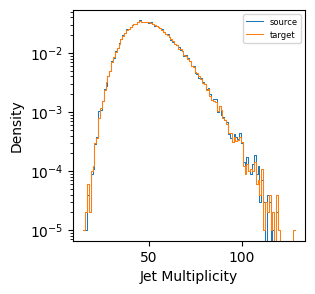

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

## Train CFM

2024-09-30 19:11:38.372087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 19:11:38.410729: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 19:11:38.411527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 19:11:39.197027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  None
      - solver method:  EulerSolver


INFO: number of training parameters: 503378
INFO: start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


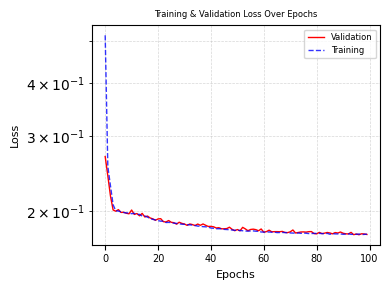

In [2]:
from cmb.models.trainers import GenerativeDynamicsModule
epic_cfm = GenerativeDynamicsModule(config, jets)
epic_cfm.train()


# Inference

### load trained model

In [3]:
from cmb.models.trainers import GenerativeDynamicsModule

path='/home/df630/CMB/results/JetClass/beta-gauss_to_tops_ConditionalMarkovBridge_EPiC_2024.09.30_18h45_8903/config.yaml'
epic_cfm = GenerativeDynamicsModule(config=path)
epic_cfm.load(checkpoint='last')


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  None
      - solver method:  EulerSolver
INFO: loading `last` epoch checkpoint from:
  - /home/df630/CMB/results/JetClass/beta-gauss_to_tops_ConditionalMarkovBridge_EPiC_2024.09.30_18h45_8903/last_epoch.ckpt


In [4]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from cmb.datasets.jetclass import JetsClassData
from cmb.datasets.jetclass import ParticleClouds

epic_cfm.config.data.source.test.num_jets = 10000
test = JetsClassData(epic_cfm.config.data, test=True)

epic_cfm.generate(source_continuous=test.source.continuous, 
                  mask=test.source.mask,
                  output_history=False
                  )

INFO: generating samples...


In [5]:
sample = ParticleClouds(epic_cfm.sample, min_num_particles=0, max_num_particles=128, discrete_features=False) 

In [6]:
log = True
args_sam = {'stat':'density', 'log_scale':(False, log), 'fill':False, 'color':'darkred', 'lw':0.75, 'label':'generated (t=1)'}
args_tar = {'stat':'density', 'log_scale':(False, log), 'fill':True, 'color':'k','lw':0.3, 'alpha':0.2, 'label':'JetClass'}
args_src = {'stat':'density', 'log_scale':(False, log), 'fill':False, 'color':'darkblue','lw':0.75, 'label':'source (t=0)'}

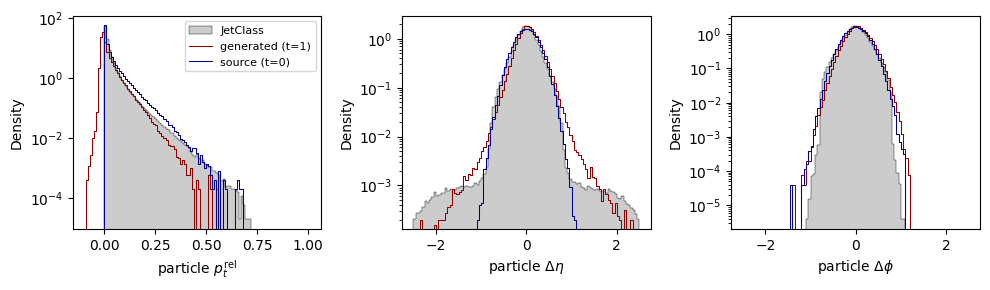

In [7]:
mask_target = (test.target.mask > 0).squeeze() 
mask_source= (test.source.mask > 0).squeeze() 
mask_sample = (sample.mask > 0).squeeze()

fig, ax = plt.subplots(1, 3, figsize=(10,3))

test.target.histplot('pt_rel', mask=mask_target,  binrange=(-.1, 1), binwidth=0.01, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_tar)
sample.histplot('pt_rel', mask=mask_sample, binrange=(-.1, 1), binwidth=0.01, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0], **args_sam)
test.source.histplot('pt_rel', mask=mask_source,  binrange=(-.1, 1), binwidth=0.01, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_src)

test.target.histplot('eta_rel', mask=mask_target,  binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_tar)
sample.histplot('eta_rel', mask=mask_sample, binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1], **args_sam)
test.source.histplot('eta_rel', mask=mask_source, binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_src)

test.target.histplot('phi_rel', mask=mask_target,  binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_tar)
sample.histplot('phi_rel', mask=mask_sample, binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2], **args_sam)
test.source.histplot('phi_rel', mask=mask_source, binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_src)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cfm.workdir / 'particle_distributions.png')
plt.show()

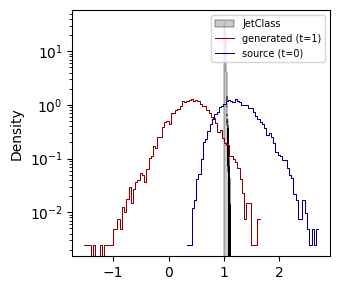

In [8]:
sample_jet_pt = sample.continuous[...,0].sum(dim=1)
target_jet_pt = test.target.continuous[...,0].sum(dim=1)
source_jet_pt = test.source.continuous[...,0].sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(target_jet_pt, element='step', **args_tar)
sns.histplot(sample_jet_pt,  element='step', **args_sam)
sns.histplot(source_jet_pt, element='step', **args_src)
ax.legend(loc='upper right', fontsize=7)

plt.tight_layout()
plt.savefig(epic_cfm.workdir / 'jet_pt.png')
plt.show()

varying number of constituents (max. 128)

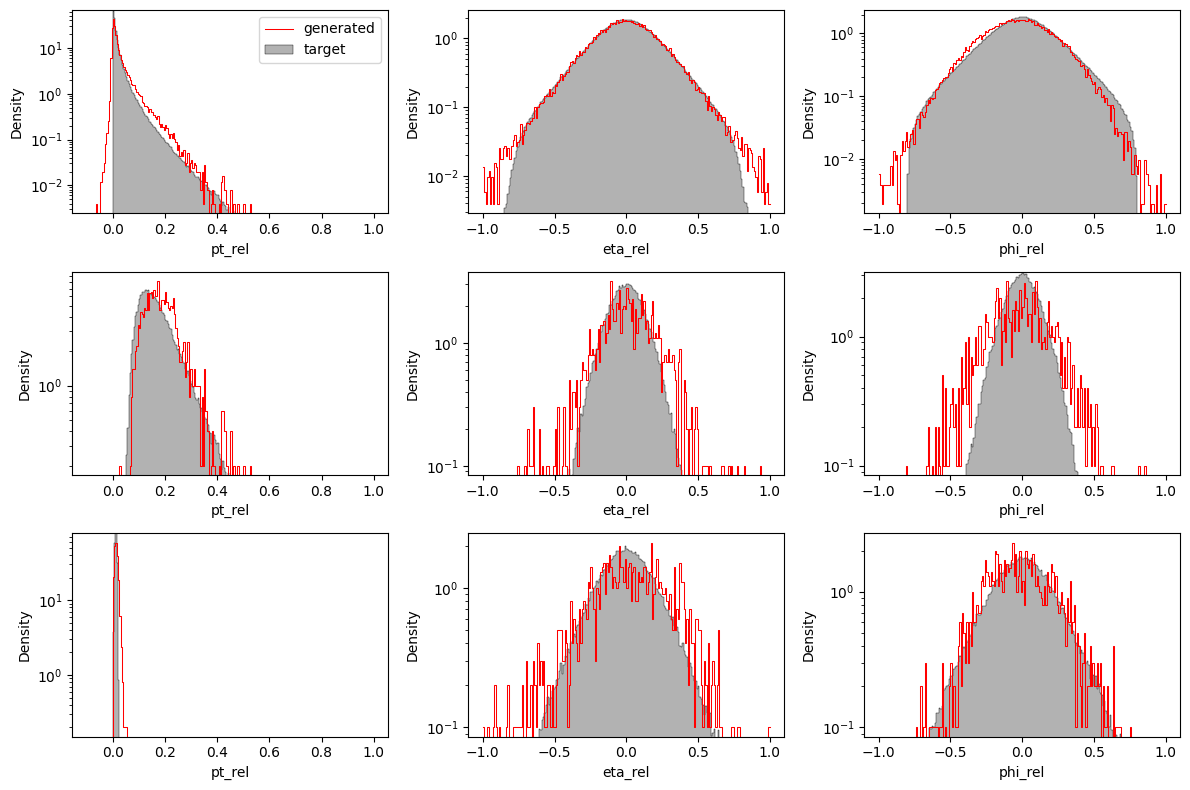

In [6]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(12,8))

binrange_0, binwidth_0 = (-0.1, 1), 0.005
binrange_1, binwidth_1 = (-1, 1), 0.01
binrange_2, binwidth_2 = (-1, 1), 0.01

jets_generated.histplot('pt_rel', binrange=binrange_0, binwidth=binwidth_0, ax=ax[0,0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', binrange=binrange_0, binwidth=binwidth_0, ax=ax[0,0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('eta_rel', binrange=binrange_1, binwidth=binwidth_1, ax=ax[0,1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', binrange=binrange_1, binwidth=binwidth_1, ax=ax[0,1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('phi_rel', binrange=binrange_2, binwidth=binwidth_2, ax=ax[0,2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel',binrange=binrange_2, binwidth=binwidth_2, ax=ax[0,2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('pt_rel', idx=0, binrange=binrange_0, binwidth=binwidth_0, ax=ax[1,0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=0, binrange=binrange_0, binwidth=binwidth_0, ax=ax[1,0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('eta_rel', idx=0, binrange=binrange_1, binwidth=binwidth_1, ax=ax[1,1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=0, binrange=binrange_1, binwidth=binwidth_1, ax=ax[1,1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('phi_rel', idx=0, binrange=binrange_2, binwidth=binwidth_2, ax=ax[1,2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=0, binrange=binrange_2, binwidth=binwidth_2, ax=ax[1,2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('pt_rel', idx=20, binrange=binrange_0, binwidth=binwidth_0, ax=ax[2,0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=20, binrange=binrange_0, binwidth=binwidth_0, ax=ax[2,0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('eta_rel', idx=20, binrange=binrange_1, binwidth=binwidth_1, ax=ax[2,1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=20, binrange=binrange_1, binwidth=binwidth_1, ax=ax[2,1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('phi_rel', idx=20, binrange=binrange_2, binwidth=binwidth_2, ax=ax[2,2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=20, binrange=binrange_2, binwidth=binwidth_2, ax=ax[2,2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[0,0].legend()
plt.tight_layout()
plt.savefig(model.workdir / 'particle_distributions.png')
plt.show()
